## In this project, we are using a precomputed databases of word embeddings - GloVe, and LSTM to predict the type of complaints. It's a multi-classification problem as there're 10 different kinds of complaints. This notebook is fully run even though it is showing blank for every <font color='green'>In [ ]</font>.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_excel('/cleansed.xlsx','sheet1')

In [ ]:
df.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
display(df.shape)
display(df.isnull().sum())
display(df['product'].value_counts())
display(df.head())
df.info()

(66696, 3)

index                           0
product                         0
consumer_complaint_narrative    0
dtype: int64

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Name: product, dtype: int64

,index,product,consumer_complaint_narrative
0,190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,190135,Consumer Loan,Due to inconsistencies in the amount owed that...
2,190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,190207,Mortgage,I have an open and current mortgage with Chase...
4,190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66696 entries, 0 to 66695
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   index                         66696 non-null  int64 
 1   product                       66696 non-null  object
 2   consumer_complaint_narrative  66696 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


## Showing the frequency of different kind of complaint

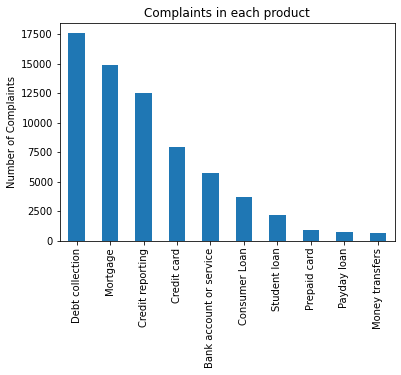

In [ ]:
df['product'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Complaints in each product',ylabel = 'Number of Complaints')

In [ ]:
def print_plot(index):
    example = df[df['index'] == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')   
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
STOPWORDS

In [ ]:
display(print_plot(289915))
print('\n')
print_plot(542250)

I SENT {$1000.00} TO XXXX THROUGH XXXX XXXX. THE RECEIVER NEVER RECEIVED THE MONEY AND XXXX XXXX REFUSES TO REFUND ME MY MONEY. THE TRACKING NUMBER IS XXXX. MY NAME IS XXXX XXXX PHONE NUMBER IS XXXX 

Product: Money transfers


None



Through CFPB, XXXX XXXX XXXX XXXX XXXX closed this account. 
Explanation of closure : " Terminated collection efforts and notified the bureaus to delete our trade line. '' Case # XXXX XXXX/XXXX/2015 

Product: Credit reporting


In [ ]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)

In [ ]:
display(print_plot(289915))
print('\n')
print_plot(542250)

sent 100000 receiver never received money refuses refund money tracking number name phone number
Product: Money transfers


None



cfpb closed account eplanation closure terminated collection efforts notified bureaus delete trade line case # 2015
Product: Credit reporting


In [ ]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+', '')   #\d+ means 1 or more digit

In [ ]:
display(print_plot(289915))
print('\n')
print_plot(542250)

sent  receiver never received money refuses refund money tracking number name phone number
Product: Money transfers


None



cfpb closed account eplanation closure terminated collection efforts notified bureaus delete trade line case # 
Product: Credit reporting


In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100


# filters: a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
# lower: boolean. Whether to convert the texts to lowercase.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [ ]:
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56726 unique tokens.


In [ ]:
word_index.items()

dict_items([('credit', 1), ('account', 2), ('would', 3), ('loan', 4), ('payment', 5), ('bank', 6), ('told', 7), ('debt', 8), ('nt', 9), ('report', 10), ('received', 11), ('mortgage', 12), ('information', 13), ('card', 14), ('called', 15), ('time', 16), ('company', 17), ('never', 18), ('pay', 19), ('payments', 20), ('call', 21), ('get', 22), ('sent', 23), ('paid', 24), ('letter', 25), ('back', 26), ('said', 27), ('could', 28), ('phone', 29), ('also', 30), ('money', 31), ('number', 32), ('made', 33), ('home', 34), ('due', 35), ('amount', 36), ('since', 37), ('asked', 38), ('us', 39), ('years', 40), ('collection', 41), ('still', 42), ('balance', 43), ('even', 44), ('days', 45), ('late', 46), ('one', 47), ('month', 48), ('make', 49), ('interest', 50), ('check', 51), ('reporting', 52), ('help', 53), ('months', 54), ('date', 55), ('contacted', 56), ('day', 57), ('service', 58), ('name', 59), ('new', 60), ('times', 61), ('know', 62), ('modification', 63), ('fees', 64), ('another', 65), ('cont

In [ ]:
pd.DataFrame(word_index, index =[0])

,credit,account,would,loan,payment,bank,told,debt,nt,report,received,mortgage,information,card,called,time,company,never,pay,payments,call,get,sent,paid,letter,back,said,could,phone,also,money,number,made,home,due,amount,since,asked,us,years,...,alcom,attendt,oir,decapitating,analyzes,midset,welloff,repayers,belittleing,effortly,fishyness,torcs,documentsverbally,tantrum,proceduresi,myrequests,andconfiscated,inquestion,payfees,sifnature,looms,trannsfers,netowrk,purcharses,northlands,transsuion,cleaar,conventions,liviing,advisd,cardshe,billaccount,eccentric,predicting,cdos,woudnt,stressfu,mamm,tdo,oopshuman
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,56687,56688,56689,56690,56691,56692,56693,56694,56695,56696,56697,56698,56699,56700,56701,56702,56703,56704,56705,56706,56707,56708,56709,56710,56711,56712,56713,56714,56715,56716,56717,56718,56719,56720,56721,56722,56723,56724,56725,56726


https://stackoverflow.com/questions/46202519/keras-tokenizer-num-words-doesnt-seem-to-work

In [ ]:
X = tokenizer.texts_to_sequences(df['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66696, 250)


In [ ]:
X[1:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [ ]:
Y = pd.get_dummies(df['product']).values
display(Y[:5])
print('\n Shape of label tensor:', Y.shape)

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=uint8)


 Shape of label tensor: (66696, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(50022, 250) (50022, 10)
(16674, 250) (16674, 10)


## GloVe embedding matrix handling

In [ ]:
f = open('/glove.6B.100d.txt')

In [ ]:
embeddings_index = {}

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((MAX_NB_WORDS, embedding_dim))

In [ ]:
for word, i in word_index.items():
  if i < MAX_NB_WORDS:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:                #嵌入索引（embeddings_index）中找不到的词，其嵌入向量全为0, 如找到,為1
      embedding_matrix[i] = embedding_vector

In [ ]:
# Let's take a look at the embedding_matrix
df_a = pd.DataFrame(embedding_matrix)
df_a[df_a[0]!=0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
1,0.546850,-0.225250,0.095015,-0.196410,0.068867,-0.55884,-0.661780,-0.426280,0.063782,0.118670,-0.014495,0.74114,-0.51318,0.17816,-0.147860,0.072782,0.39947,-0.270280,0.33603,0.31553,-0.41967,0.60735,-0.048756,0.158370,-0.457950,-0.55579,-0.91885,-0.499610,-0.53053,0.051961,0.704110,0.79850,-0.57392,0.057146,-0.24607,-0.27500,0.359650,-0.009739,-0.21164,-0.48524,...,0.355600,-0.28317,-0.463630,0.13305,0.43720,0.19550,0.13308,0.24792,1.40990,-0.39776,-0.75765,0.43834,-0.743920,-0.32341,0.240290,0.737090,-0.482200,0.082007,-1.13920,-0.554470,1.30490,-0.22703,-0.585360,-0.73344,-1.3389,0.048373,-0.599040,-0.616220,-0.034904,-0.561910,-0.37943,0.74357,0.12011,-0.95975,0.047241,0.693420,0.89529,0.21689,0.21705,0.140790
2,-0.043476,0.086186,0.437450,0.002965,0.183090,0.24904,0.013582,-0.001049,0.332830,-0.326280,0.207810,0.45421,0.12788,0.15245,0.363010,-0.111260,0.36760,-0.133680,-0.12557,0.28236,0.40866,-0.52496,0.149910,0.647690,-0.774980,-1.03810,-0.42347,0.077851,-0.20793,-0.483800,0.423870,0.43056,-0.38914,-0.491460,-0.27155,-0.16908,0.417890,0.384850,-0.26094,-0.33477,...,0.097511,0.11250,-0.034599,-0.60110,1.05950,-0.48638,0.23123,0.16330,0.69467,-0.18156,0.01662,0.41181,0.400190,-0.20391,0.055939,0.045798,0.044785,-0.367020,-0.89394,-0.047691,0.70084,0.76794,0.063643,-0.28959,-1.2712,-0.559140,-0.206120,-0.508380,-0.038394,0.054433,0.13438,0.54929,0.56662,-1.07090,-0.008977,0.140550,0.28088,-0.78872,0.13494,0.074029
3,0.039741,0.035052,0.329880,-0.587900,-0.250540,-0.40719,-0.139040,0.473930,0.059905,0.089996,-0.215210,0.56533,0.30099,-0.28658,-0.055730,-0.787240,0.48656,0.583210,-0.86199,0.20924,0.46740,-0.36396,0.305260,0.042185,-0.053602,-0.27202,-0.28585,-0.541700,0.29678,-0.408680,0.097381,0.81001,-0.20864,0.184780,0.18757,0.85580,0.440710,0.252180,-0.18148,-0.19156,...,-0.136040,0.58236,-0.488740,0.11841,1.18590,0.10033,0.26320,1.00950,-0.34785,-0.93080,0.41517,-1.17740,-0.334770,-0.52506,0.047776,-0.233900,-0.228570,0.310050,-1.06550,0.051151,0.72159,-0.52556,-0.458820,-0.16729,-1.8869,-0.489960,0.822110,0.007792,0.072314,-0.467950,-0.13359,-0.32797,-0.27505,-0.31342,-0.677630,0.015973,0.28487,-0.26137,0.55433,0.245100
4,0.631820,0.302040,-0.016361,-0.214060,-0.073581,-0.29067,-0.086409,0.294870,-0.128250,0.224720,0.757460,0.41768,-0.88171,0.20696,0.015155,0.243130,0.42907,0.086946,0.87812,0.53346,-1.05150,0.41999,-0.473260,0.674550,-0.414990,-0.71863,-0.64540,-0.503980,-1.21570,0.063252,-0.228390,0.57422,-0.37943,0.145320,-0.51243,0.55354,0.334730,0.050025,-0.33119,-0.74341,...,0.315200,-0.45327,-1.009000,-0.13406,0.46828,0.15950,-0.24051,0.98081,0.31871,-0.86702,-0.25590,-0.24872,-0.273340,-0.58394,0.228620,0.196710,-0.641780,0.648330,-1.21370,-0.410110,1.08300,0.45249,0.080174,-0.96438,-1.0732,0.401270,-0.599530,-0.150360,0.037520,-0.674940,-0.84174,0.37997,-0.32168,-0.49395,0.174220,0.395770,0.76905,0.92579,0.72736,-1.160900
5,0.507040,0.091956,-0.027891,0.393410,-0.157030,-0.10963,-0.165010,0.341720,0.216000,0.084716,0.360920,0.77434,-0.12734,0.10272,0.061516,-0.761640,0.10506,0.006204,0.39297,0.21254,-0.57192,-0.18958,-0.409880,0.569790,0.077706,-0.52043,-0.26613,-0.284890,-0.33310,-0.227350,0.501640,0.43952,-0.27827,-0.397790,0.23188,0.18033,0.019995,0.021986,-0.18470,-0.84372,...,0.717780,-0.61413,-0.393940,-0.36699,0.59689,-0.86352,-0.49243,0.19188,0.67244,-1.10400,-0.79688,-0.27466,-0.024599,0.19638,0.603990,0.392780,0.005725,-0.105820,-0.98909,0.032559,1.29390,0.07793,0.253940,-0.95983,-1.4927,0.164260,-0.017027,-0.458020,-0.024842,-0.538380,-0.39914,0.29882,-0.18136,-0.55235,-0.024438,-0.203540,1.28370,0.72178,0.86294,-0.638700


In [ ]:
# checker
for word, i in word_index.items():
  if i== 9 or i ==56:
    print(word,i)
    print(embeddings_index.get(word))

nt 9
['0.3181' '1.0088' '-0.2626' '0.7227' '0.45135' '0.19292' '0.4785'
 '0.12901' '0.42915' '0.49066' '0.39372' '0.62924' '-0.032235' '-1.0556'
 '0.35913' '-1.6065' '0.016057' '0.55847' '0.31763' '0.48992' '0.71925'
 '-1.0343' '0.071459' '0.82903' '0.45216' '-0.13417' '0.065534' '-0.17885'
 '-0.75011' '-0.81097' '-0.027646' '0.97922' '0.37517' '0.23123'
 '-0.078519' '0.82679' '-0.03469' '0.062159' '0.011452' '-0.42789'
 '0.022286' '-1.0482' '-0.085792' '-0.0212' '0.69419' '-0.60116'
 '-0.73011' '-0.87395' '-0.19218' '-1.2337' '-0.046497' '-0.0026118'
 '0.44485' '0.13541' '-0.55196' '-0.11449' '-0.12221' '-0.27518' '1.6607'
 '1.1224' '-0.24187' '-0.18394' '-1.5932' '1.0117' '-1.6398' '-0.61205'
 '0.28202' '0.55858' '1.5506' '0.22403' '-0.11118' '0.080295' '0.10696'
 '0.39408' '-0.38976' '0.038053' '-0.41572' '0.8306' '-0.47187' '0.80252'
 '0.56251' '0.053719' '-0.372' '-1.1966' '-0.25634' '1.38' '0.13696'
 '0.30828' '0.95762' '0.13164' '0.92941' '1.125' '-0.062296' '-0.77058'
 '0.34437

# Start building the model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 5,081,410
Trainable params: 81,410
Non-trainable params: 5,000,000
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 128
##/313 313 is sample size (sample size * batch_size/validation_split ~ 50000) 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
313/313 [==============================] - 289s 911ms/step - loss: 1.6799 - accuracy: 0.4102 - val_loss: 1.0150 - val_accuracy: 0.6846
Epoch 2/10
313/313 [==============================] - 290s 925ms/step - loss: 1.0343 - accuracy: 0.6720 - val_loss: 0.7827 - val_accuracy: 0.7545
Epoch 3/10
313/313 [==============================] - 286s 915ms/step - loss: 0.8188 - accuracy: 0.7419 - val_loss: 0.7153 - val_accuracy: 0.7746
Epoch 4/10
313/313 [==============================] - 286s 915ms/step - loss: 0.7333 - accuracy: 0.7661 - val_loss: 0.6535 - val_accuracy: 0.7891
Epoch 5/10
313/313 [==============================] - 288s 920ms/step - loss: 0.6767 - accuracy: 0.7832 - val_loss: 0.6243 - val_accuracy: 0.7981
Epoch 6/10
313/313 [==============================] - 287s 916ms/step - loss: 0.6364 - accuracy: 0.7966 - val_loss: 0.5943 - val_accuracy: 0.8065
Epoch 7/10
313/313 [==============================] - 285s 911ms/step - loss: 0.6082 - accuracy: 0.8029 - val_loss: 0.5836 -

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

522/522 [==============================] - 38s 73ms/step - loss: 0.5255 - accuracy: 0.8282
Test set
  Loss: 0.525
  Accuracy: 0.828


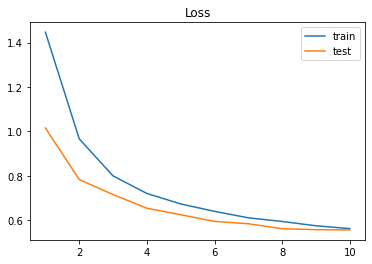

In [ ]:
plt.title('Loss')
plt.plot(range(1, 11),history.history['loss'], label='train')
plt.plot(range(1, 11),history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

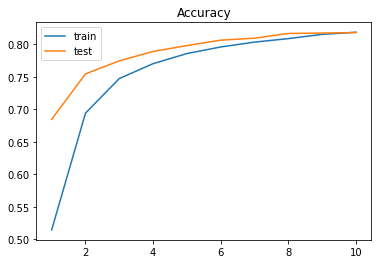

In [ ]:
plt.title('Accuracy')
plt.plot(range(1, 11),history.history['accuracy'], label='train')
plt.plot(range(1, 11),history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# checker
pd.get_dummies(df['product']).columns

Index(['Bank account or service', 'Consumer Loan', 'Credit card',
       'Credit reporting', 'Debt collection', 'Money transfers', 'Mortgage',
       'Payday loan', 'Prepaid card', 'Student loan'],
      dtype='object')

In [ ]:
outcome = model.predict(X_test)

In [ ]:
reverse_word_index = {value: key for (key, value) in word_index.items()}

def decode_integers(integers):
    PAD = 0
    text = ""
    for num in integers:
      if num != PAD:
        text += reverse_word_index[num] + " "

    return text[:-1]

In [ ]:
# checker
decode_integers(X_test[2])

'contacted phone right around year date past due payment citizens bank visa owed approimately nt tell right dispute offered settle reduced rate funds provide said could work payment plan monthly told could nt afford pay much back payments monthly since also told know responsibility pay back wanted pay back told nt working idea would returning work nt substantial earnings tried several places employment symptoms return quit job holding employment pt mo less working since week know manage month nt take autopay payment nt contact payment taken month since think paid back close already may taken autopay reported lost stolen debit card sent new one different debit card called eplain receiving statement could leave message call nt taken addition called let know recently found collect payment collections fearful take money month garnishment bank account processed may believe intentional part would break phone agreement made also contacting ask take money legally represent nt allowed thank rev

## Building a DataFrame to show each product probability, narrative, actual and prediction

In [ ]:
comments = []
comments_prediction = []
for i in range(len(X_test)):
  comments.append(decode_integers(X_test[i]))

for i in range(len(Y_test)):
  comments_prediction.append(np.argmax(Y_test[i]))

In [ ]:
display(comments[:3])
comments_prediction[:3]

['wells fargo approved mortgage could longer work pay mortgage time subsequent year kept property offering give bank deed lieu foreclosure year talked less individuals bank never ones got conflicting information bank started foreclosure action time offered bank deed lieu foreclosure understanding would seek deficiency judgment lawyer bank finally agreed proposal offered month however still took bank lawyer court appointed referee months judgment foreclosure sale occur scheduled eactly years offered property bank meantime spending months year period starting get health back complaints would bank take deed lieu soon became obvious resources pay mortgage bank take steps protect property eg leave power heat minimal heat settings avoid finally happened frozen pipes overwhelming mildew black mold house finally sells bank get pennies dollar failed protect property years trying get credit back buy car reasonable terms fault bank law firms handling foreclosure action get strong sense bank mecha

[6, 4, 4]

In [ ]:
df_prediction = pd.DataFrame(outcome, columns = pd.get_dummies(df['product']).columns)

In [ ]:
df_prediction['narrative'] = comments
df_prediction['narrartive_label'] = comments_prediction

In [ ]:
df_prediction['Prediction'] = df_prediction[['Bank account or service', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Debt collection', 'Money transfers', 'Mortgage',
       'Payday loan', 'Prepaid card', 'Student loan']].idxmax(axis=1)
df_prediction['narrative_label'] = df_prediction['narrartive_label'].map(
    {
        0: 'Bank account or service'
        ,1: 'Consumer Loan'
        ,2: 'Credit card'
        ,3: 'Credit reporting'
        ,4: 'Debt collection'
        ,5: 'Money transfers'               
        ,6: 'Mortgage'
        ,7: 'Payday loan'
        ,8: 'Prepaid card'
        ,9: 'Student loan'}
)
df_prediction['Correct'] = np.where(df_prediction.Prediction == df_prediction.narrative_label,1,0)

In [ ]:
df_prediction.head(3)

,Bank account or service,Consumer Loan,Credit card,Credit reporting,Debt collection,Money transfers,Mortgage,Payday loan,Prepaid card,Student loan,narrative,narrartive_label,Prediction,narrative_label,Correct
0,0.007349,0.001547,0.001048,0.000851,0.001272,0.000152,0.987481,0.000082,0.000007,0.000212,wells fargo approved mortgage could longer wor...,6,Mortgage,Mortgage,1
1,0.000105,0.001766,0.003439,0.260519,0.733104,0.000005,0.000078,0.000222,0.000006,0.000756,already filed complaints need find another deb...,4,Debt collection,Debt collection,1
2,0.090055,0.020963,0.282401,0.012640,0.551762,0.002473,0.008133,0.008830,0.003817,0.018926,contacted phone right around year date past du...,4,Debt collection,Debt collection,1


In [ ]:
sum(df_prediction['Correct'])/df_prediction.shape[0]

0.8281756027347967

## Accuracy breakdown by product

In [ ]:
df3 = pd.DataFrame(df_prediction['narrative_label'].value_counts())
df3['incorrect_count'] = df_prediction[df_prediction['Correct'] == 0]['narrative_label'].value_counts()
df3['incorrect %'] = df3['incorrect_count'] / df3.narrative_label
df3['proportion'] = df3.narrative_label / sum(df3.narrative_label)
df3

# Althought Prepaid card and Money transfers engages only 1% each, their incorrect % are quite low.
# The performance of the model wasn't bad, with an accuracy of 82.8%.

,narrative_label,incorrect_count,incorrect %,proportion
Debt collection,4448,775,0.174236,0.266763
Mortgage,3766,200,0.053107,0.225861
Credit reporting,3079,350,0.113673,0.184659
Credit card,1995,374,0.187469,0.119647
Bank account or service,1398,357,0.255365,0.083843
Consumer Loan,897,456,0.508361,0.053796
Student loan,534,127,0.237828,0.032026
Prepaid card,212,46,0.216981,0.012714
Payday loan,193,130,0.673575,0.011575
Money transfers,152,50,0.328947,0.009116


## new complaint prediction
### let's try testing a complaint about Money transfers as it has the lowest proportion among the products.

[[0.18167698 0.03442694 0.04450539 0.12827303 0.16811992 0.2322007
  0.09326334 0.01903745 0.09131643 0.00717984]] 
 Money transfers 



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

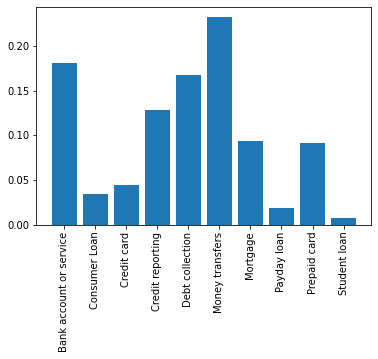

In [ ]:
new_complaint = ['I am very disappointed I did not transfer $5000 successfully throught the atm machine']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Bank account or service', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Debt collection', 'Money transfers', 'Mortgage',
       'Payday loan', 'Prepaid card', 'Student loan']
print(pred, '\n',labels[np.argmax(pred)],'\n')

plt.bar(x=labels, height = pred[0], )
plt.xticks(rotation = 90)

# the model predicts correctly!

# Citation
- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
- Chollet François. Deep Learning with Python. Manning Publications Co., 2018.